# Ten Years Stroke project

This project aims to construct a Bayesian Network model to analyze and quantify the primary risk factors relevant to heart disease prevention.

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pgmpy.estimators import HillClimbSearch, BicScore, MmhcEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork

from pgmpy.estimators.CITests import chi_square
from sklearn.metrics import classification_report,f1_score,precision_score
from pgmpy.inference import VariableElimination

c:\Users\mtarenzi\AppData\Local\miniforge3\envs\stroke_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
dataframe = pd.read_csv('tenyear_stroke.csv')
dataframe.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


# 1. Data Exploration

In [3]:
# Set the desired dataframe
dataframe = dataframe[dataframe['BPMeds']==0]

data = dataframe[['age','totChol','sysBP','diaBP','BMI','cigsPerDay','male','diabetes','TenYearCHD']]
data.loc[:,'TenYearCHD'] = data['TenYearCHD'].map({1:'At-Risk',0:'Healthy'})

C:\Users\mtarenzi\AppData\Local\Temp\ipykernel_29104\4236959516.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Healthy' 'Healthy' 'Healthy' ... 'Healthy' 'Healthy' 'Healthy']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:,'TenYearCHD'] = data['TenYearCHD'].map({1:'At-Risk',0:'Healthy'})


### Correlation

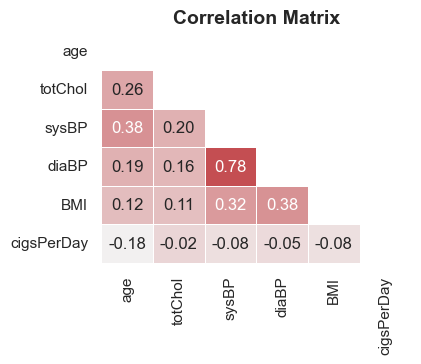

In [4]:
# Correlation matrix
corr_matrix = data[['age','totChol','sysBP','diaBP','BMI','cigsPerDay']].corr()

plt.figure(figsize=(4, 3))  
sns.set(style="white")
cmap=sns.color_palette("light:r", as_cmap=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool),k=0)

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap=cmap,
    fmt='.2f',
    linewidths=0.5,
    cbar=False
)

plt.title("Correlation Matrix", fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()


### Frequency histograms

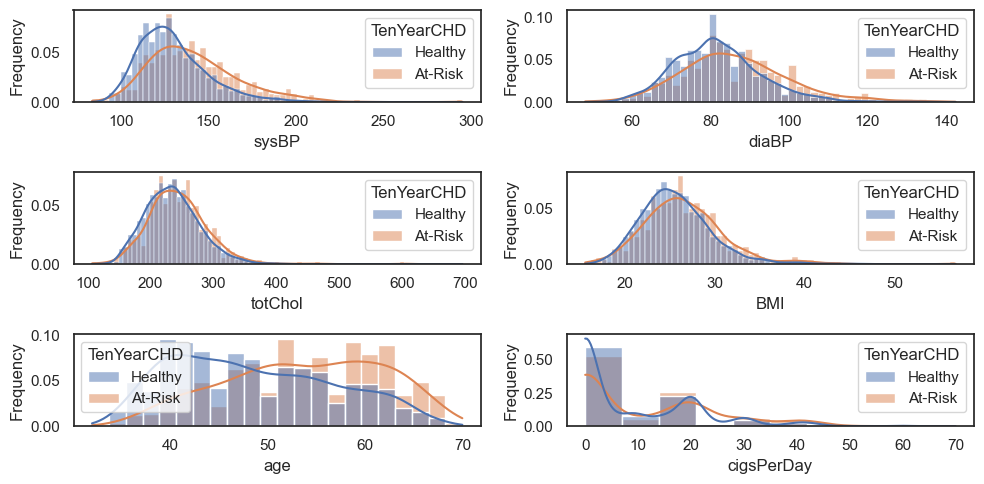

In [5]:
fig, axes = plt.subplots(3, 2, figsize=(10, 5))
features = ['sysBP','diaBP','totChol','BMI','age','cigsPerDay']

axes = axes.flatten()

custom_bins = [-1, 100, 400]


for i, feature in enumerate(features):
    if feature != 'cigsPerDay':
        sns.histplot(data=data,x=dataframe[feature], kde=True, ax=axes[i],hue='TenYearCHD',stat='probability',common_norm=False)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
    else:
        sns.histplot(data=data,x=dataframe[feature], kde=True, ax=axes[i],hue='TenYearCHD',stat='probability',common_norm=False,bins=10)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        
    

plt.tight_layout()
plt.show()


## Outliers

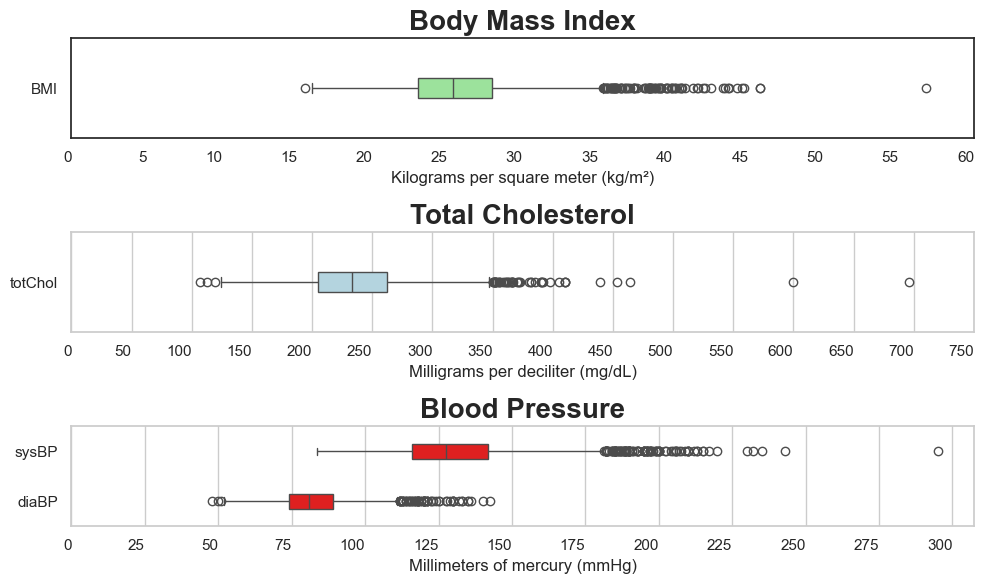

In [6]:
plt.figure(figsize=(10, 6))  # Adjust the figure size to fit both plots

# Plot for Body Mass Index (BMI)
plt.subplot(3, 1, 1)  
sns.set(style="whitegrid")
sns.boxplot(data=data[['BMI']], width=0.2, orient='h',color='lightgreen')
plt.title("Body Mass Index", fontsize=20, fontweight='bold')
plt.xticks(range(0, 61, 5), rotation=0, ha='right')
plt.xlabel("Kilograms per square meter (kg/m²)")

# Plot for Total Cholesterol
plt.subplot(3, 1, 2) 
sns.set(style="whitegrid")
sns.boxplot(data=data[['totChol']], width=0.2, orient='h',color='lightblue')
plt.title("Total Cholesterol", fontsize=20, fontweight='bold')
plt.xticks(range(0, 800, 50), rotation=0, ha='right')
plt.xlabel("Milligrams per deciliter (mg/dL)")

plt.subplot(3,1,3)
sns.set(style="whitegrid")

sns.boxplot(data=data[['sysBP','diaBP']],width=0.3,orient='h',color='red') 

plt.title("Blood Pressure", fontsize=20, fontweight='bold') 
plt.xticks(range(0, 301, 25),rotation=0, ha='right')
plt.xlabel("Millimeters of mercury (mmHg)") 

plt.tight_layout()
plt.show()

# 2. Data Engeneering

Transform continuous data to discrete using medical information.

In [7]:
from skimpy import skim 

skim(data[['age','totChol','sysBP','diaBP','BMI','cigsPerDay']])

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 4061   │ │ float64     │ 5     │                                                          │
│ │ Number of columns │ 6      │ │ int64       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┓  │
│ ┃ column      ┃ NA  ┃ NA %                ┃ mean   ┃ sd     ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100  ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━┩  │
│ │ age         │   0 │                   0 │  49.35 │  8.511 │    32 │    42 │    48 │    56 │    70 │ ▃▇▇▇▅▂ │  │
│ │ totChol     │  46 │  1.1327259295739966 │  236.1 │  44.23 │   107 │   205 │   233 │   262 │   696 │  ▃▇▁   │  │
│ │ sysBP       │   0 │                   0 │  131.3 │   21.1 │  83.5 │   116 │ 127.5 │   142 │   295 │  ▅▇▂   │  │
│ │ diaBP       │   0 │                   0 │  82.48 │  11.62 │    48 │    74 │    81 │    89 │ 142.5 │  ▁▆▇▂  │  │
│ │ BMI         │  18 │  0.4432405811376508 │  25.73 │   4.02 │ 15.54 │ 23.06 │ 25.36 │ 27.96 │  56.8 │  ▂▇▂   │  │
│ │ cigsPerDay  │  29 │  0.7141098251662152 │   9.11 │  11.96 │     0 │     0 │     0 │    20 │    70 │  ▇▃▁   │  │
│ └─────────────┴─────┴─────────────────────┴────────┴────────┴───────┴───────┴───────┴───────┴───────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [35]:
# Function does not accept missing values
data_cl = data.dropna()

In [36]:
# Age
data_cl = data_cl[(data_cl['age'] >= 30) & (data_cl['age'] <= 75)]
data_cl['age'] = pd.cut(data_cl.age,bins=[29,44,54,64,75],labels=['30-44','45-54','55-64','65-75'],ordered=True).astype(str)

# Cholesterol-level
data_cl = data_cl[(data_cl['totChol'] >= 100) & (data_cl['totChol'] <= 425)]
data_cl['totChol'] = pd.cut(data_cl.totChol,bins=[99,199,239,500],labels=['Optimal','Elevated','High'],ordered=False).astype(str)

# Body Mass Index 
data_cl = data_cl[(data_cl['BMI'] <= 50)]
data_cl['BMI'] = pd.cut(data_cl.BMI,bins=[14.,18.4,24.9,29.9,50],labels=['Underweight','Normal','Overweight','Obese'],ordered=False).astype(str)

#Cigs Per Day 
data_cl = data_cl[(data_cl['cigsPerDay'] <= 50)]
data_cl['cigsPerDay'] = pd.cut(data_cl.cigsPerDay,bins=[-1,0,5,19,50],labels=['NonSmoker','LightSmoker','ModerateSmoker','SevereSmoker'],ordered=False).astype(str)

In [37]:
# Create a Blood pressure variable

bloodP= []

# Systolic-Pressure
data_cl = data_cl[(data_cl['sysBP'] >= 40) & (data_cl['sysBP'] <= 225)]
# Diastolic-Pressure
data_cl = data_cl[(data_cl['diaBP'] >= 40) &(data_cl['diaBP'] <= 140)]

for i,sys in enumerate(data_cl.sysBP.values):
    dia = data_cl.diaBP.values[i]

    if (sys<=120 and dia<=80):
        blood = 'Optimal'
    elif (sys<=140 and dia<=90):
        blood = 'Elevated'
    elif(sys<=180 and dia<=120): 
        blood = 'Hypertension'
    else:
        blood ='Crisis'
    bloodP.append(blood)
    
data_cl['BP'] = bloodP

In [38]:
# Rename features and adjust the final dataset

data_cl.columns=['Age','TotChol','SBP','DBP','BMI','CigsxDay','Gender','Diabetes','TYCD','BloodP']
data_cl = data_cl[['Age','TotChol','SBP','DBP','BMI','CigsxDay','Gender','Diabetes','BloodP','TYCD']]

data_cl['Gender'] = data_cl['Gender'].map({1:'Male',0:'Female'})
data_cl['Diabetes'] = data_cl['Diabetes'].map({1:'Diabetic',0:'Healthy'})

dataset = data_cl.drop(['SBP','DBP'],axis=1)
dataset = dataset.astype('str')

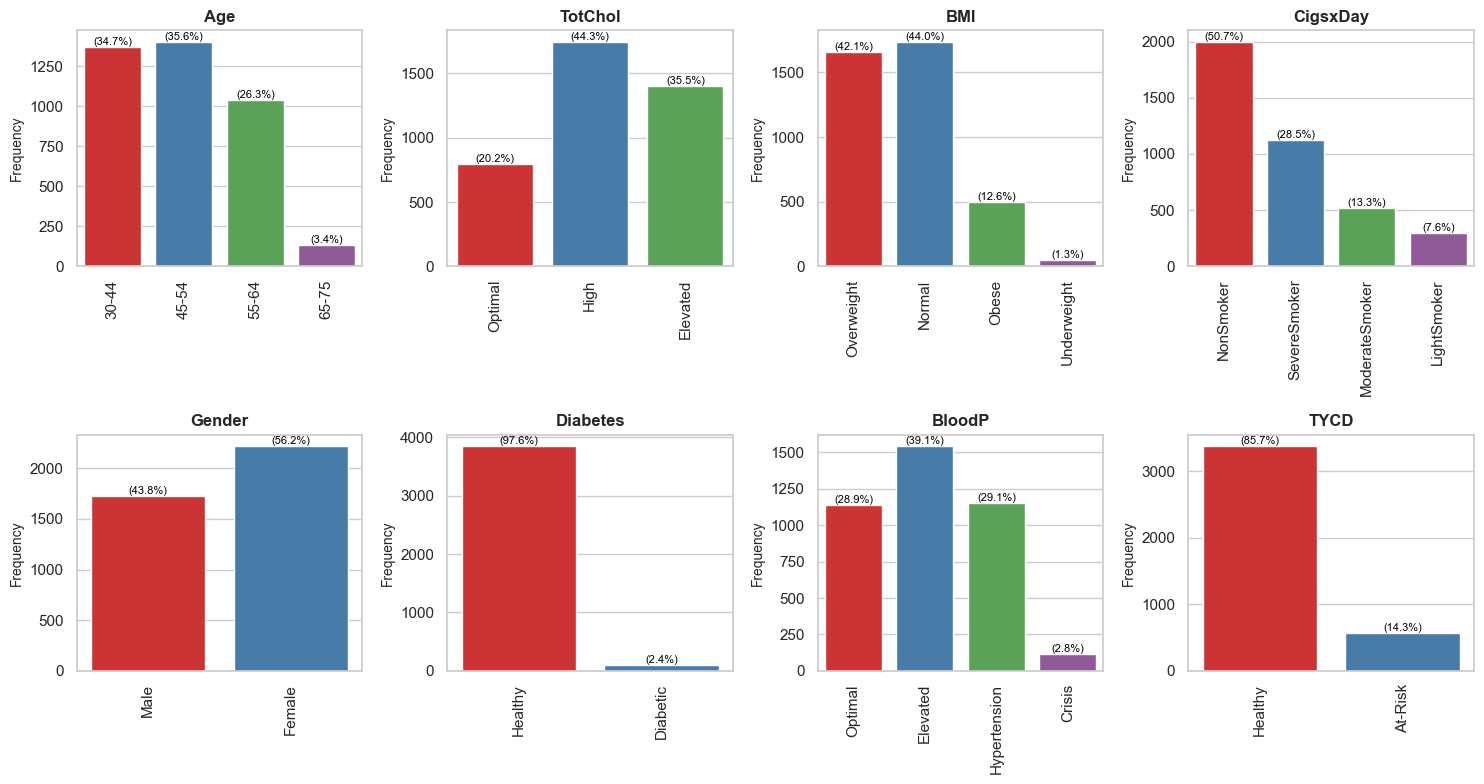

In [39]:
# Give a look at the frequency of the new categorical variables

fig, axes = plt.subplots(2, 4, figsize=(15, 8)) 
features = dataset.columns.to_list()  
axes = axes.flatten()

# Loop through each feature 
for i, feature in enumerate(features):
    sns.countplot(data=dataset, x=feature, ax=axes[i], palette='Set1',hue=feature)  
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].set_xlabel('') 
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].set_title(f'{feature}', fontsize=12, fontweight='bold')

    # Total number of rows in the dataset
    total_count = len(dataset)
    
    # Annotate the bars with frequencies
    for p in axes[i].patches:
        height = p.get_height()
        frequency = height / total_count
 
        axes[i].annotate(f'({frequency*100:.1f}%)', 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='bottom', fontsize=8, color='black')

plt.tight_layout()
plt.show()

# 3. Definition of Bayesian Network

## a. Hill search

In [40]:
# Set some boundaries
fixeed_edges = [('Age','BMI'),('Age','BloodP'),('Gender','BMI'),('CigsxDay','BloodP'),('BloodP','TYCD')]
forbidden_edges = [(node,'Age') for node in dataset.columns] + \
                  [(node,'Gender') for node in dataset.columns] + \
                   [(node,'CxD') for node in dataset.columns]

# Define the method
score = HillClimbSearch(dataset)

best_model = score.estimate(scoring_method=BicScore(dataset),max_indegree=10,
                            fixed_edges=fixeed_edges,black_list=forbidden_edges)

# Construct the network
hill_model=BayesianNetwork(best_model.edges())
hill_model.fit(dataset, estimator=MaximumLikelihoodEstimator)
hill_model.check_model()


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 6/1000000 [00:00<13:47:41, 20.14it/s]


True

## b. Hybrid method

In [41]:
mmhc = MmhcEstimator(dataset)
skeleton = mmhc.mmpc()

# use hill climb search 
hc = HillClimbSearch(dataset)
hybrid_model = hc.estimate(tabu_length=10, white_list=skeleton.to_directed().edges(), scoring_method=BicScore(dataset))
print("Hybrid Model: ", hybrid_model.edges())

  0%|          | 8/1000000 [00:00<4:04:08, 68.27it/s]

Hybrid Model:  [('Age', 'BloodP'), ('Age', 'TotChol'), ('Age', 'TYCD'), ('BMI', 'Gender'), ('CigsxDay', 'Gender'), ('CigsxDay', 'Age'), ('BloodP', 'BMI'), ('TYCD', 'Diabetes')]


## c. Personal definition

In [42]:
# Run test on independence 
print(chi_square(X='Age',Y='Gender', Z=[] ,data=dataset, significance_level = 0.05))

True


In [43]:
cust_edges = [  ('Age','BMI'),('Age','TotChol'),
                ('Gender','BMI'),('Gender','TotChol'),       # Set the dependency of gender and age
                ('CigsxDay','BMI'),
                
                ('CigsxDay','Diabetes'),('BMI','Diabetes'), # Set diabetes
                ('CigsxDay','BloodP'),('BMI','BloodP'),('TotChol','BloodP'),('Diabetes','BloodP'), # Set blood pressure
                
                ('BloodP','TYCD'),('Diabetes','TYCD'),('CigsxDay','TYCD'),('Age','TYCD')] 

cust_model= BayesianNetwork(cust_edges)
cust_model.fit(dataset, estimator=MaximumLikelihoodEstimator)
cust_model.check_model()

True

## Compare the two models using Bayesian Information Criteria

In [44]:
bic = BicScore(dataset)

print(f'Model_hill BIC: {bic.score(hill_model)}')
print(f'Hybrid model BIC: {bic.score(hybrid_model)}')
print(f'Custom model BIC: {bic.score(cust_model)}')

Model_hill BIC: -26597.844984166502
Hybrid model BIC: -26322.606387824573
Custom model BIC: -28312.095888547377


### Give a better look at the custom model

In [45]:
#An image of the model

# 4. Variable elimination and predictions

## a. Variable Elimination 

In [46]:
infer = VariableElimination(cust_model)

glu_infer = infer.query(variables=['TYCD'], evidence={'BMI':'Normal','BloodP':'Optimal','CigsxDay':'NonSmoker'})
print(glu_infer)

+---------------+-------------+
| TYCD          |   phi(TYCD) |
+===============+=============+
| TYCD(At-Risk) |      0.0603 |
+---------------+-------------+
| TYCD(Healthy) |      0.9397 |
+---------------+-------------+


In [47]:
glu_infer = infer.query(variables=['TYCD'], evidence={'BMI':'Obese','BloodP':'Crisis','CigsxDay':'SevereSmoker'})
print(glu_infer)

+---------------+-------------+
| TYCD          |   phi(TYCD) |
+===============+=============+
| TYCD(At-Risk) |      0.3775 |
+---------------+-------------+
| TYCD(Healthy) |      0.6225 |
+---------------+-------------+


In [48]:
def get_prob(variable,evidence):

    ev_cat = sorted(dataset[evidence].unique().tolist())
    var_cat = sorted(dataset[variable].unique().tolist())

    # Crea DataFrame
    df = pd.DataFrame({f'{variable}\{evidence}': var_cat})

    for category in ev_cat:
        res = infer.query(variables=[variable], evidence={f'{evidence}':category})
        df[category]=res.values

    print(df)


In [49]:
get_prob('TYCD','BloodP')

  TYCD\BloodP    Crisis  Elevated  Hypertension   Optimal
0     At-Risk  0.269019  0.121538      0.193017  0.098585
1     Healthy  0.730981  0.878462      0.806983  0.901415


In [50]:
get_prob('BloodP','BMI')

     BloodP\BMI    Normal     Obese  Overweight  Underweight
0        Crisis  0.015314  0.070512    0.029899     0.009615
1      Elevated  0.397577  0.321470    0.411538     0.388128
2  Hypertension  0.190011  0.489935    0.343245     0.104419
3       Optimal  0.397098  0.118083    0.215319     0.497837


In [51]:
get_prob('TYCD','Age')

  TYCD\Age     30-44     45-54     55-64     65-75
0  At-Risk  0.066011  0.137776  0.220655  0.289878
1  Healthy  0.933989  0.862224  0.779345  0.710122


In [52]:
get_prob('BloodP','BMI')

     BloodP\BMI    Normal     Obese  Overweight  Underweight
0        Crisis  0.015314  0.070512    0.029899     0.009615
1      Elevated  0.397577  0.321470    0.411538     0.388128
2  Hypertension  0.190011  0.489935    0.343245     0.104419
3       Optimal  0.397098  0.118083    0.215319     0.497837


In [53]:
get_prob('BloodP','CigsxDay')

  BloodP\CigsxDay  LightSmoker  ModerateSmoker  NonSmoker  SevereSmoker
0          Crisis     0.027183        0.025540   0.037496      0.013375
1        Elevated     0.399165        0.344315   0.391468      0.420030
2    Hypertension     0.283249        0.238248   0.330272      0.247651
3         Optimal     0.290403        0.391898   0.240764      0.318943


In [54]:
get_prob('TYCD','CigsxDay')

  TYCD\CigsxDay  LightSmoker  ModerateSmoker  NonSmoker  SevereSmoker
0       At-Risk     0.107719        0.150766   0.115254      0.187436
1       Healthy     0.892281        0.849234   0.884746      0.812564


## b. Predictions

### Divide in subsets

In [76]:
# DIVIDE IN TRAIN AND TEST
from imblearn.over_sampling import SMOTEN

X = dataset.drop(['TYCD'],axis=1)
y = dataset[['TYCD']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_train, y_train, test_size=0.2)
# Initialize SMOTENC
smoten = SMOTEN(sampling_strategy=0.25)

# Apply SMOTE
X_train, y_train = smoten.fit_resample(X_train, y_train)

train_net = pd.concat([X_train,y_train],axis=1)
val_net = pd.concat([X_val,y_val],axis=1)
test_net =  pd.concat([X_test,y_test],axis=1)

c:\Users\mtarenzi\AppData\Local\miniforge3\envs\stroke_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\mtarenzi\AppData\Local\miniforge3\envs\stroke_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\mtarenzi\AppData\Local\miniforge3\envs\stroke_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer AP

In [77]:
# Fit the network on train data

inf_model= BayesianNetwork(cust_edges)
inf_model.fit(train_net, estimator=MaximumLikelihoodEstimator)
inf_model.check_model()

True

### Obtain the best threshold

In [78]:
# Run predictions on validation
true_values = []
predicted_probs = []

inference = VariableElimination(cust_model)
keys_to_keep = [node for node in cust_model.nodes()]


# Iterate over each row in the test set (assuming 'test_net' is your test data)
for index, row in val_net.iterrows():
    
    evidence = row.to_dict()
    evidence = {k: v for k, v in evidence.items() if k in keys_to_keep}
    del evidence['TYCD']
    
    # Use the trained Bayesian network model to predict the probability distribution of 'Y'
    prediction = inference.query(variables=['TYCD'], evidence=evidence)
  
    predicted_prob=prediction.values[0]
            
    # True value of 'Y' from the test set
    true_y = row['TYCD']
    
    # Append true and predicted values
    true_values.append(true_y)
    predicted_probs.append(predicted_prob)

In [79]:
# Initialize variables to track best threshold and its corresponding f1 score
best_threshold = 0
best_f1_weighted = 0

# Range of thresholds to test
thresholds = np.linspace(0, 1, 100)

# Store F1 scores for plotting
f1_scores = []

# Loop over thresholds to find the best one
for threshold in thresholds:
    # Classify labels based on the threshold
    predicted_values = ['At-Risk' if pred >= threshold else 'Healthy' for pred in predicted_probs]
    
    # Compute weighted F1 score
    f1_weighted = f1_score(true_values,predicted_values,pos_label='At-Risk')
    f1_scores.append(f1_weighted)
    
    # Update best threshold if this F1 score is better
    if f1_weighted > best_f1_weighted:
        best_f1_weighted = f1_weighted
        best_threshold = threshold

# Print the best threshold and corresponding weighted F1 score
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1_weighted:.4f}")


Best Threshold: 0.18
Best F1 Score: 0.3684


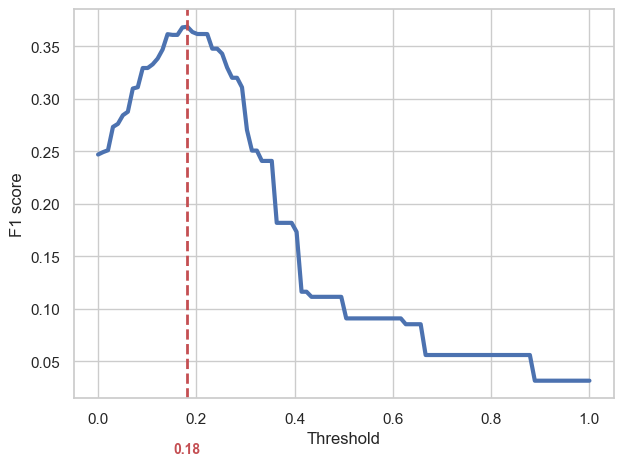

In [80]:
# Plotting the mean of a numerical variable across categories of a categorical variable
sns.lineplot( x=thresholds, y=f1_scores,linewidth=3)

# Set title and labels
plt.xlabel('Threshold')
plt.ylabel('F1 score')

plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Threshold = {best_threshold}',linewidth=2)
plt.text(best_threshold, -0.04, f'{best_threshold:.2f}', fontsize=10, ha='center', va='bottom', color='r',fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

### Evaluate on test set

In [81]:
from pgmpy.inference import VariableElimination

true_values = []
predicted_probs = []

inference = VariableElimination(cust_model)
keys_to_keep = [node for node in cust_model.nodes()]


# Iterate over each row in the test set (assuming 'test_net' is your test data)
for index, row in test_net.iterrows():
    
    evidence = row.to_dict()
    evidence = {k: v for k, v in evidence.items() if k in keys_to_keep}
    del evidence['TYCD']

    remove_list = []
    for var in cust_model.nodes():
        if var not in evidence.keys():
            remove_list.append
    
    # Use the trained Bayesian network model to predict the probability distribution of 'Y'
    prediction = inference.query(variables=['TYCD'], evidence=evidence)
    
    predicted_prob=prediction.values[0]
            
    # True value of 'Y' from the test set
    true_y = row['TYCD']
    
    # Append true and predicted values
    true_values.append(true_y)
    predicted_probs.append(predicted_prob)

In [82]:
predicted_values = ['At-Risk' if pred >= best_threshold else 'Healthy' for pred in predicted_probs]
report = classification_report(true_values,predicted_values,labels=['Healthy','At-Risk'],zero_division=False)

print(report)

              precision    recall  f1-score   support

     Healthy       0.91      0.71      0.80       468
     At-Risk       0.28      0.62      0.39        85

    accuracy                           0.70       553
   macro avg       0.60      0.67      0.59       553
weighted avg       0.82      0.70      0.74       553

